In [1]:
import os
from salvus.toolbox import toolbox
SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "local_server")
from salvus.flow import api
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import time
import xarray as xr
from salvus.flow import simple_config as config
import salvus.namespace as sn
from pyasdf import ASDFDataSet
import gstools as gs
import warnings
warnings.filterwarnings("ignore")


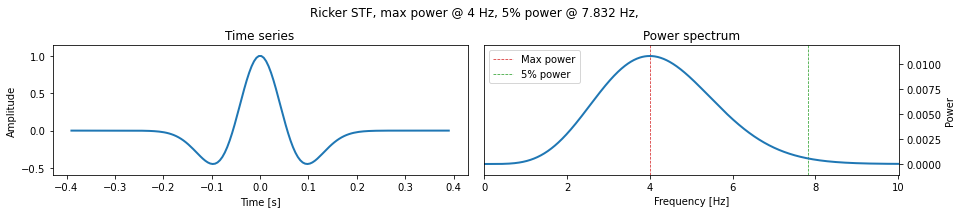

In [2]:
# define source parameters, check Salvus website for more info
SRC_FREQ = 4.0
MAX_FREQ = 10.0
SIMULATION_TIME = 5.0

# Wavelet:
wavelet = config.stf.Ricker(center_frequency=SRC_FREQ)
wavelet.plot()

# Acoustic

In [3]:
nx, ny = 64, 64
x = np.linspace(-5e3, 5e3, nx)
y = np.linspace(-5e3, 5e3, ny)
xx, yy = np.meshgrid(x, y, indexing="ij")

vp0 = 3000.0 * np.ones_like(xx)
rho0 = 2200.0 * np.ones_like(xx)

# source location
srcxy = (np.random.random((2))-0.5)/0.5*5000

# Receivers:
recx = xx.flatten()
recy = yy.flatten()

FIELD = "phi" # acoustic
recs = [
        config.receiver.cartesian.Point2D(
            x=recx[_j], y=recy[_j], station_code=f"{_j:05d}", fields=[FIELD]
            )
        for _j in range(0, len(recx), 1)
        ]


src = config.source.cartesian.ScalarPoint2D(
    source_time_function=wavelet, x=srcxy[0], y=srcxy[1],  f=1.0)




In [4]:
ds = xr.Dataset(
    data_vars={
        "vp": (["x", "y"], vp0 ),
        "rho": (["x", "y"], rho0 ),
    },
    coords={"x": x, "y": y},
  )

mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=ds,
    slowest_velocity="vp",
    maximum_frequency=MAX_FREQ,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(["x0", "x1", "y0", "y1"], 0),
)

s = config.simulation.Waveform(mesh=mesh, sources=src, receivers=recs)

# Set end time:
s.physics.wave_equation.end_time_in_seconds = SIMULATION_TIME

# Initialize first-order absorbing boundary conditions:
boundaries = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0", "y1"], taper_amplitude=SRC_FREQ, width_in_meters=0.0
)

# Add the boundaries to the parameter file:
s.physics.wave_equation.boundaries = [boundaries]

# Wavefield output format:
s.output.point_data.format = "asdf"

s.validate()

t1=time.time()
api.run(
    input_file=s,
    ranks=4,
    site_name=SALVUS_FLOW_SITE_NAME,
    get_all=True,
    output_folder="output_tmp",
    overwrite=True,
)
print(time.time()-t1)

a = ASDFDataSet('output_tmp/' + "receivers.h5", mode="r")

t1=time.time()
fs = 100
nt = 5 # sec
npts = fs * nt
tmp=np.zeros((nx*ny, npts))
flag = 0
for ii in a.waveforms:
    tmp[flag,:] = ii['phi'][0].resample(fs).data[:npts] # 100 Hz, 500 samples, 5 sec
    flag +=1
    
data = tmp.reshape(nx,ny,npts)

print(time.time()-t1)
os.system("rm -rf output_tmp")

Job `job_2211181554075578_fe76c391d0` running on `local_server` with 4 rank(s).
Site information:
  * Salvus version: 0.11.36
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/781 [00:00<?, ?it/s]

* Downloaded 24.0 MB of results to `output_tmp`.
* Total run time: 15.02 seconds.
* Pure simulation time: 11.67 seconds.
15.028673887252808
7.121233940124512


256

# Elastic 2D

In [5]:
nx, ny = 64, 64
x = np.linspace(-5e3, 5e3, nx)
y = np.linspace(-5e3, 5e3, ny)
xx, yy = np.meshgrid(x, y, indexing="ij")

vs0 = 3000.0 * np.ones_like(xx)
vp0 = 5000.0 * np.ones_like(xx)
rho0 = 2200.0 * np.ones_like(xx)


# source location
srcxy = (np.random.random((2))-0.5)/0.5*5000

# Receivers:
recx = xx.flatten()
recy = yy.flatten()

FIELD = "displacement" # elastic
recs = [
        config.receiver.cartesian.Point2D(
            x=recx[_j], y=recy[_j], station_code=f"{_j:05d}", fields=[FIELD]
            )
        for _j in range(0, len(recx), 1)
        ]

src = config.source.cartesian.MomentTensorPoint2D(
        source_time_function=wavelet, x=srcxy[0], y=srcxy[1],   mxx=1.0, myy=1.0, mxy=0.0)

In [6]:
ds = xr.Dataset(
    data_vars={
        "vp": (["x", "y"], vp0),
        "vs": (["x", "y"], vs0),
        "rho": (["x", "y"], rho0),

    },
    coords={"x": x, "y": y},
  )

mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=ds,
    slowest_velocity="vs",
    maximum_frequency=MAX_FREQ,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(["x0", "x1", "y0", "y1"], 0),
)

s = config.simulation.Waveform(mesh=mesh, sources=src, receivers=recs)

# Set end time:
s.physics.wave_equation.end_time_in_seconds = SIMULATION_TIME

# Initialize first-order absorbing boundary conditions:
boundaries = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0", "y1"], taper_amplitude=SRC_FREQ, width_in_meters=0.0
)

# Add the boundaries to the parameter file:
s.physics.wave_equation.boundaries = [boundaries]

# Wavefield output format:
s.output.point_data.format = "asdf"

s.validate()

t1=time.time()
api.run(
    input_file=s,
    ranks=4,
    site_name=SALVUS_FLOW_SITE_NAME,
    get_all=True,
    output_folder="output_tmp",
    overwrite=True,
)
print(time.time()-t1)

a = ASDFDataSet('./output_tmp/' + "receivers.h5", mode="r")

t1=time.time()
fs = 100
nt = 5 # sec
npts = fs * nt
tmp=np.zeros((nx*ny, npts, 2))
flag = 0
for ii in a.waveforms:
    tmp[flag,:,0] = ii['displacement'][0].resample(fs).data[:npts]
    tmp[flag,:,1] = ii['displacement'][1].resample(fs).data[:npts]
    flag +=1

data = tmp.reshape(nx,ny,npts,2)
print(time.time()-t1)
os.system("rm -rf ./output_tmp")

Job `job_2211181554025686_f821fa5afe` running on `local_server` with 4 rank(s).
Site information:
  * Salvus version: 0.11.36
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/1301 [00:00<?, ?it/s]

* Downloaded 55.1 MB of results to `output_tmp`.
* Total run time: 21.93 seconds.
* Pure simulation time: 19.96 seconds.
21.939627170562744
20.137454509735107


256

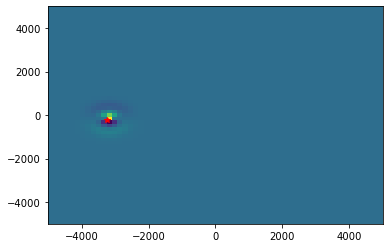

In [7]:
plt.pcolormesh(xx,yy,data[:,:,40,1])
plt.plot(srcxy[0],srcxy[1],'r*')